In [37]:
import numpy as np
import pandas
import pandas_profiling
import matplotlib.pyplot as plt
import gymnasium
import gym
import random
import time
from gymnasium.wrappers import RecordVideo
import tensorflow as tf
from collections import namedtuple, deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [38]:
#  sets the precision to 3 decimal places.
np.set_printoptions(precision=3)

# Enviroment Setup (Mode 2 is the real game)
Game Mode 0 (default) - 15

Changing the Game Mode (Good For Testing Generalisation of the model) 

In [39]:
mode = 2
env = gym.make("SpaceInvaders-v0", render_mode='rgb_array', mode=mode)
output_dir = "deep-q-learning_video"
video_output_frequency = 20
env = RecordVideo(env, output_dir, episode_trigger=lambda episode_id: episode_id == 1 or (episode_id != 0 and (episode_id) % video_output_frequency == 0))
env.metadata['render_fps'] = 24

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:182: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


undestanding the dimensions of the data

In [40]:
height, width, channels = env.observation_space.shape
actions = env.action_space.n
print(height, width, channels)
print(actions)

210 160 3
6


In [41]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

# Testing the Env

    Confirmed Working

In [42]:
""" episodes = 100

for episode in range(0, episodes+1):
    env.close()
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1,2,3,4,5])
        new_state, reward, done, _, info = env.step(action)
        score+=reward
    
    if(episode > 0):
        print('Episode:{} Score:{}'.format(episode, score))
 """

" episodes = 100\n\nfor episode in range(0, episodes+1):\n    env.close()\n    state = env.reset()\n    done = False\n    score = 0 \n    \n    while not done:\n        env.render()\n        action = random.choice([0,1,2,3,4,5])\n        new_state, reward, done, _, info = env.step(action)\n        score+=reward\n    \n    if(episode > 0):\n        print('Episode:{} Score:{}'.format(episode, score))\n "

# Why Deep Q-Learning

We discovered with Q-learning that it was not possible to train the agent with the Q-Learning algorithm due to the limitations of the Q-Table. The state returned by env.reset() and env.step(action) in the Atari environments is a full image from the game screen. Pixel values range from 0 to 255, and most of them will not correspond to valid indices in your Q-table.

Therefore we will utilize Deep Q-Learning to solve this issue.

## Creating a Deep Learning Model with Keras

In [43]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [44]:
model = build_model(height, width, channels, actions)

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 51, 39, 32)        6176      
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 18, 64)        32832     
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 16, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 22528)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               11534848  
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 6)                

## Creating the Q-Learning Algorithm

In [46]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(actions)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [47]:
from collections import deque

replay_buffer = deque(maxlen=2000)

Note: for very large replay buffers, you may want to use a circular buffer instead, as random access time will be O(1) instead of O(N). Or you can check out DeepMind's Reverb library.

In [48]:
""" # extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices] """

' # extra code – A basic circular buffer implementation\n\nclass ReplayBuffer:\n    def __init__(self, max_size):\n        self.buffer = np.empty(max_size, dtype=object)\n        self.max_size = max_size\n        self.index = 0\n        self.size = 0\n\n    def append(self, obj):\n        self.buffer[self.index] = obj\n        self.size = min(self.size + 1, self.max_size)\n        self.index = (self.index + 1) % self.max_size\n\n    def sample(self, batch_size):\n        indices = np.random.randint(self.size, size=batch_size)\n        return self.buffer[indices] '

In [49]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [50]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [51]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, e_actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(e_actions, actions)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [52]:
point_scores = pandas.DataFrame(columns=['score'])
rewards = []
total_point_score = 0
num_episodes = 100
best_score = 0

In [53]:
for episode in range(0, num_episodes + 1):
    obs, info = env.reset()
    done = False
    total_point_score = 0

    while not done:
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

        total_point_score += reward

    point_scores = pandas.concat([point_scores, pandas.DataFrame({'score': [total_point_score]})], ignore_index=True)
    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode}, total_point_score: {total_point_score}, eps: {epsilon:.3f}",
          end="")
    
    rewards.append(total_point_score)
    if total_point_score >= best_score:
        best_weights = model.get_weights()
        best_score = total_point_score

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – 

Episode: 0, total_point_score: 80.0, eps: 1.000Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4
Episode: 1, total_point_score: 110.0, eps: 0.998

2023-05-12 11:58:32.722232: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Episode: 19, total_point_score: 45.0, eps: 0.9624Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4
Episode: 20, total_point_score: 165.0, eps: 0.960

Episode: 39, total_point_score: 105.0, eps: 0.922Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-40.mp4
Episode: 59, total_point_score: 215.0, eps: 0.882Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-60.mp4
Episode: 79, total_point_score: 190.0, eps: 0.842Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-80.mp4
Episode: 99, total_point_score: 110.0, eps: 0.802Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-100.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-100.mp4
Episode: 100, total_point_score: 130.0, eps: 0.800

In [54]:
point_scores.describe()

,score
count,101.000000
mean,148.861386
std,96.739033
min,30.000000
25%,85.000000
50%,120.000000
75%,180.000000
max,515.000000


In [55]:
point_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   101 non-null    float64
dtypes: float64(1)
memory usage: 936.0 bytes


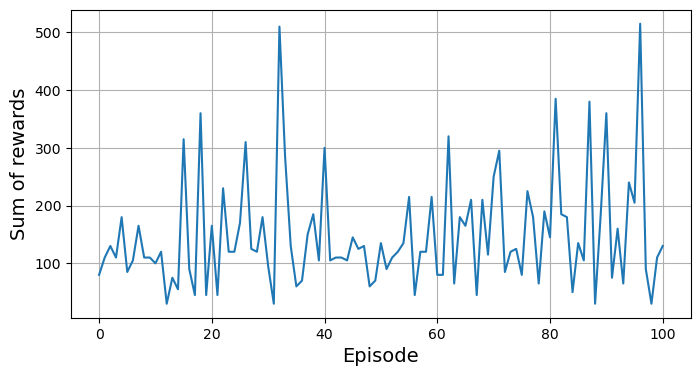

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

## Build Agent with Keras-RL

## Agent Setup (this need to point the trained agent)

In [57]:
def agent(env):
    """Random agent that samples actions from the environment's action space."""
    return env.action_space.sample()

# Agent Testing

In [58]:
""" def get_agent_scores(num_episodes = 1):
    scores = pandas.DataFrame(columns=['score'])
    total_reward = 0
    #highest_score = 0
    
    for _ in range(0, num_episodes + 1):
        #if(_ > 1 and total_reward > 0):
        #    print(f'Game Episode {_ - 1}: Score: {total_reward}')
        env.close()
        total_reward = 0
        observation, info = env.reset()  # Getting start stats from the game
        lives = info['lives']  # Initialize lives inside the loop
        while lives != 0:
            # For demonstration purposes, we use a random agent
            action = agent(env)   # Just a random agent
            obs, reward, terminated, truncated, info = env.step(action)
            lives = info['lives']
            total_reward = total_reward + reward

        # Update highest score if current total reward is higher
        #if total_reward > highest_score:
        #    highest_score = total_reward

        scores = pandas.concat([scores, pandas.DataFrame({'score': [total_reward]})], ignore_index=True)


    """ # Print the highest score achieved
    print(f"Highest Score: {highest_score}") """

    # Close the environment to finalize the video recording
    scores = scores.drop(scores.index[0])
    return scores
 """

IndentationError: unexpected indent (1960065885.py, line 28)

In [ ]:
num_episodes = 100

scores = get_agent_scores(num_episodes = num_episodes)



Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4
Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-1.mp4


Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4
Moviepy - Building video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/archit3ct/Code/Assignments/AI_Mandatory_2/Timothy/deep-q-learning_video/rl-video-episode-20.mp4


# Descriptive Statistics of Agent Performance

In [ ]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 1 to 100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   100 non-null    float64
dtypes: float64(1)
memory usage: 932.0 bytes


In [ ]:
scores.head()

,score
1,165.0
2,35.0
3,35.0
4,110.0
5,45.0


In [ ]:
scores.tail()

,score
96,90.0
97,160.0
98,35.0
99,90.0
100,125.0


In [ ]:
scores.describe()

,score
count,100.000000
mean,155.050000
std,117.553974
min,10.000000
25%,80.000000
50%,125.000000
75%,185.000000
max,650.000000


In [ ]:

index_start = 0
index_end = num_episodes-1

print(f"Game Episode 1: Score {scores.iloc[index_start]['score']}\nGame Episode {num_episodes}: Score {scores.iloc[index_end]['score']}")

Game Episode 1: Score 165.0
Game Episode 100: Score 125.0


In [ ]:
print(f"Lowest Score: {scores['score'].min()}\nHigh Score: {scores['score'].max()}")

Lowest Score: 10.0
High Score: 650.0


## Mode (most frequent element)
It is possible for a sample to have multiple modes. In statistics, a mode refers to the value or values in a dataset that occur most frequently. If there are multiple values with the same highest frequency, the dataset is considered multimodal.

In [ ]:
scores.mode()

,score
0,155.0


## Median (middle value of the data set)

In [ ]:
scores.median()

score    125.0
dtype: float64

## Mean (average)

In [ ]:
scores.mean()

score    155.05
dtype: float64

## Variance (Dissimilarity between samples)

For samples degrees of freedom (ddof) is 0.

Note: The number is high due there is a lot of Dissimilarities between each score.

$$\sigma=\frac{\sum\left(x_i-\mu\right)^2}{n}\text{ for samples (degrees of freedom is 0)}$$ 

In [ ]:
scores.var(ddof=0)

score    13680.7475
dtype: float64

## Standard Deviation ( variability within a sample)
For samples degrees of freedom (ddof) is 0.

$$SD_0=\sqrt{\frac{\sum\left(x_i-\mu\right)^2}{n}}\text{ for samples (degrees of freedom is 0)}$$

In [ ]:

scores.std(ddof=0)

score    116.964728
dtype: float64

# Report Generation

In [ ]:
report = pandas_profiling.ProfileReport(scores).to_file('test_agent_scores_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]